# Setup

In [18]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
import os
import plotting

In [3]:
with open("data/hopsworks-token.txt") as f:
    hopsworks_api_key = f.read().rstrip()

In [4]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 7, 16, 55, 14, 817829)

# Hopswork connecting

In [7]:
project = hopsworks.login(api_key_value=hopsworks_api_key)
fs = project.get_feature_store()

secrets = hopsworks.connection(host="c.app.hopsworks.ai", api_key_value=hopsworks_api_key).get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country = location["country"]
city = location["city"]
street = location["street"]

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1160342
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


In [10]:
feature_view = fs.get_feature_view(
    name="air_quality_view",
    version=1,
)

In [11]:
mr = project.get_model_registry()
retrieved_model = mr.get_model(
    name="air_quality_model",
    version=1,
)
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [12]:
retrieved_xgbm = XGBRegressor()
retrieved_xgbm.load_model(os.path.join(saved_model_dir, "model.json"))
retrieved_xgbm

XGBRegressor(base_score='4.8137035E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float'], gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Make the predictions

In [13]:
weather_fg = fs.get_feature_group(
    name="weather",
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.95s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-11-08 00:00:00+00:00,11.25,0.0,4.349896,155.556061,reutlingen
1,2024-11-12 00:00:00+00:00,7.00,0.2,9.178235,348.690094,reutlingen
2,2024-11-14 00:00:00+00:00,5.90,0.1,15.716793,290.095306,reutlingen
3,2024-11-11 00:00:00+00:00,8.95,0.1,11.298495,292.479462,reutlingen
4,2024-11-13 00:00:00+00:00,6.10,0.0,6.792466,32.005356,reutlingen
5,2024-11-09 00:00:00+00:00,13.30,0.0,2.276840,71.564964,reutlingen
6,2024-11-15 00:00:00+00:00,7.85,0.0,3.826853,138.814178,reutlingen
7,2024-11-10 00:00:00+00:00,11.55,0.0,4.379589,9.462248,reutlingen


In [14]:
batch_data["predicted_pm25"] = retrieved_xgbm.predict(
    batch_data[["temperature_2m_mean", "precipitation_sum", "wind_speed_10m_max", "wind_direction_10m_dominant"]])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25
0,2024-11-08 00:00:00+00:00,11.25,0.0,4.349896,155.556061,reutlingen,7.424354
1,2024-11-12 00:00:00+00:00,7.00,0.2,9.178235,348.690094,reutlingen,6.965396
2,2024-11-14 00:00:00+00:00,5.90,0.1,15.716793,290.095306,reutlingen,6.858435
3,2024-11-11 00:00:00+00:00,8.95,0.1,11.298495,292.479462,reutlingen,5.058235
4,2024-11-13 00:00:00+00:00,6.10,0.0,6.792466,32.005356,reutlingen,7.240317
5,2024-11-09 00:00:00+00:00,13.30,0.0,2.276840,71.564964,reutlingen,4.570922
6,2024-11-15 00:00:00+00:00,7.85,0.0,3.826853,138.814178,reutlingen,14.843624
7,2024-11-10 00:00:00+00:00,11.55,0.0,4.379589,9.462248,reutlingen,6.005173


In [15]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         8 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          8 non-null      float32            
 2   precipitation_sum            8 non-null      float32            
 3   wind_speed_10m_max           8 non-null      float32            
 4   wind_direction_10m_dominant  8 non-null      float32            
 5   city                         8 non-null      object             
 6   predicted_pm25               8 non-null      float32            
dtypes: datetime64[us, UTC](1), float32(5), object(1)
memory usage: 420.0+ bytes


In [16]:
batch_data["street"] = street
batch_data["city"] = city
batch_data["country"] = country
batch_data["days_before_forecast_day"] = range(1, len(batch_data) + 1)
batch_data = batch_data.sort_values(by=["date"])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-08 00:00:00+00:00,11.25,0.0,4.349896,155.556061,reutlingen,7.424354,zaisentalstraße,germany,1
5,2024-11-09 00:00:00+00:00,13.30,0.0,2.276840,71.564964,reutlingen,4.570922,zaisentalstraße,germany,6
7,2024-11-10 00:00:00+00:00,11.55,0.0,4.379589,9.462248,reutlingen,6.005173,zaisentalstraße,germany,8
3,2024-11-11 00:00:00+00:00,8.95,0.1,11.298495,292.479462,reutlingen,5.058235,zaisentalstraße,germany,4
1,2024-11-12 00:00:00+00:00,7.00,0.2,9.178235,348.690094,reutlingen,6.965396,zaisentalstraße,germany,2
4,2024-11-13 00:00:00+00:00,6.10,0.0,6.792466,32.005356,reutlingen,7.240317,zaisentalstraße,germany,5
2,2024-11-14 00:00:00+00:00,5.90,0.1,15.716793,290.095306,reutlingen,6.858435,zaisentalstraße,germany,3
6,2024-11-15 00:00:00+00:00,7.85,0.0,3.826853,138.814178,reutlingen,14.843624,zaisentalstraße,germany,7


In [17]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, 0 to 6
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         8 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          8 non-null      float32            
 2   precipitation_sum            8 non-null      float32            
 3   wind_speed_10m_max           8 non-null      float32            
 4   wind_direction_10m_dominant  8 non-null      float32            
 5   city                         8 non-null      object             
 6   predicted_pm25               8 non-null      float32            
 7   street                       8 non-null      object             
 8   country                      8 non-null      object             
 9   days_before_forecast_day     8 non-null      int64              
dtypes: datetime64[us, UTC](1), float32(5), int64(1), object(3)


# Monitoring and graphing

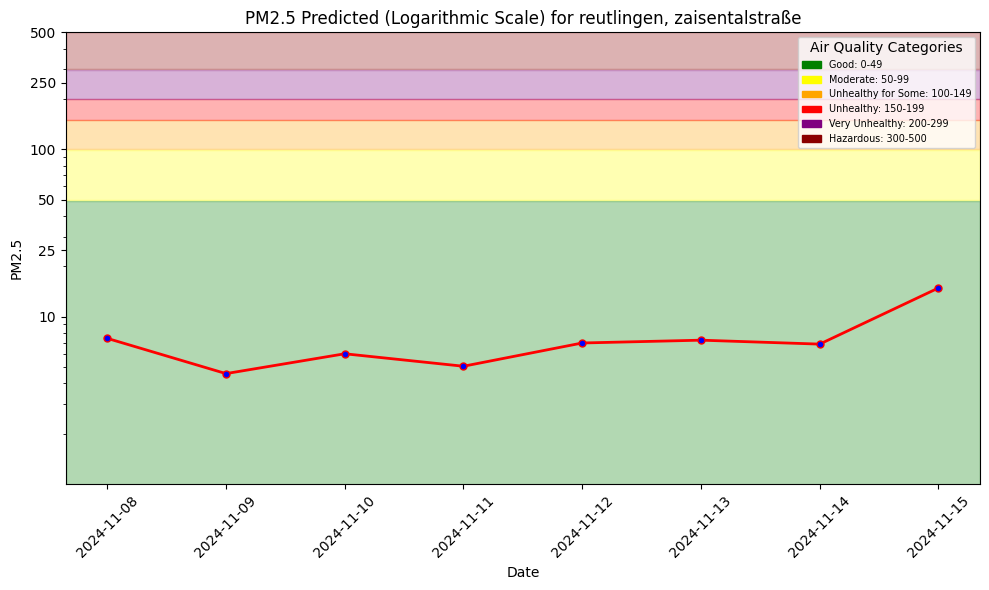

In [19]:
forecast_path = os.path.join("aqm", "images", "fc.png")
plt = plotting.plot_air_quality_forecast(city, street, batch_data, forecast_path)
plt.show()

In [20]:
monitor_fg = fs.get_or_create_feature_group(
    name="aq_predictions",
    description="Air Quality prediction monitoring",
    version=1,
    primary_key=["city", "street", "date", "days_before_forecast_day"],
    event_time="date"
)

In [21]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1160342/fs/1151045/fg/1340786


Uploading Dataframe: 0.00% |          | Rows 0/8 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1160342/jobs/named/aq_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x294edf8f0>, None)

In [22]:
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (4.48s) from Hopsworks, using Hopsworks Feature Query Service.   Reading data from Hopsworks, using Hopsworks Feature Query Service...   Reading data from Hopsworks, using Hopsworks Feature Query Service.   


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-08 00:00:00+00:00,11.25,0.0,4.349896,155.556061,reutlingen,7.424354,zaisentalstraße,germany,1


In [23]:
air_quality_fg = fs.get_feature_group(
    name="air_quality",
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.20s) 


,date,pm25,country,city,street,url
0,2022-10-05 00:00:00+00:00,3.10,germany,reutlingen,zaisentalstraße,https://api.waqi.info/feed/A54451
1,2023-04-07 00:00:00+00:00,4.12,germany,reutlingen,zaisentalstraße,https://api.waqi.info/feed/A54451
2,2023-04-11 00:00:00+00:00,1.42,germany,reutlingen,zaisentalstraße,https://api.waqi.info/feed/A54451
3,2021-09-15 00:00:00+00:00,3.80,germany,reutlingen,zaisentalstraße,https://api.waqi.info/feed/A54451
4,2020-04-26 00:00:00+00:00,1.98,germany,reutlingen,zaisentalstraße,https://api.waqi.info/feed/A54451
...,...,...,...,...,...,...
1781,2024-03-10 00:00:00+00:00,2.23,germany,reutlingen,zaisentalstraße,https://api.waqi.info/feed/A54451
1782,2024-04-17 00:00:00+00:00,2.20,germany,reutlingen,zaisentalstraße,https://api.waqi.info/feed/A54451
1783,2019-12-20 00:00:00+00:00,4.48,germany,reutlingen,zaisentalstraße,https://api.waqi.info/feed/A54451
1784,2021-05-23 00:00:00+00:00,0.80,germany,reutlingen,zaisentalstraße,https://api.waqi.info/feed/A54451


In [26]:
outcome_df = air_quality_df[["date", "pm25"]]
preds_df =  monitoring_df[["date", "predicted_pm25"]]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=["date"])

def backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, model):
    features_df = weather_fg.read()
    features_df = features_df.sort_values(by=['date'], ascending=True)
    features_df = features_df.tail(10)
    features_df['predicted_pm25'] = model.predict(features_df[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
    df = pd.merge(features_df, air_quality_df[['date','pm25','street','country']], on="date")
    df['days_before_forecast_day'] = 1
    hindcast_df = df
    df = df.drop('pm25', axis=1)
    monitor_fg.insert(df, write_options={"wait_for_job": True})
    return hindcast_df

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgbm)
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.02s) 


Uploading Dataframe: 0.00% |          | Rows 0/1 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1160342/jobs/named/aq_predictions_1_offline_fg_materialization/executions


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,pm25,street,country,days_before_forecast_day
0,2024-11-06 00:00:00+00:00,10.55,0.0,5.495161,328.392548,reutlingen,6.817208,55.0,zaisentalstraße,germany,1


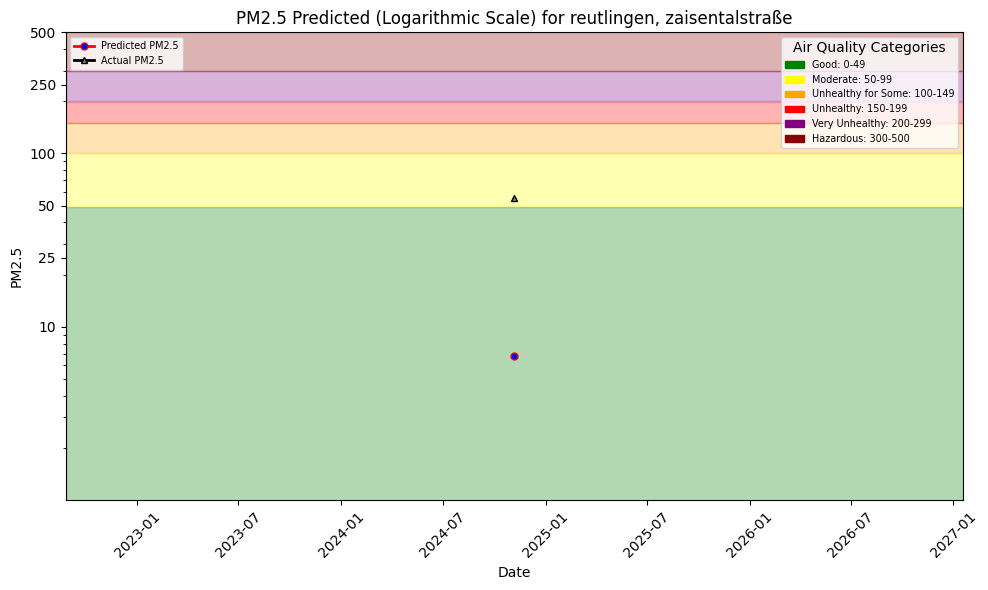

In [30]:
hindcast_path = os.path.join("aqm", "images", "fc.png")
plt = plotting.plot_air_quality_forecast(city, street, hindcast_df, hindcast_path, hindcast=True)
plt.show()